# Data pre-processing

**Tasks**
* Read and clean data (based on relevant shape files & original food crises dataset)


## 1. Read Data

* Food crisis data: https://microdata.worldbank.org/index.php/catalog/3811
* Shapefile data: Source: https://fews.net/fews-data/334


In [16]:
import pandas as pd
import geopandas as gpd

In [17]:
# READ FOOD CRISIS DATA - Downloaded from world bank
FS = pd.read_csv('Data\predicting_food_crises_data.csv')

# Select country(s) of interest
country_removal = set(FS['country'].tolist())
country_removal = [e for e in country_removal if e not in ('Burkina Faso', 'Mali', 'Niger')]
for i in country_removal:
    FS.drop(FS.loc[FS['country'] == i].index, inplace=True)
# Reset index
FS = FS.reset_index()
FS = FS.drop(['index'], axis=1)

<AxesSubplot:>

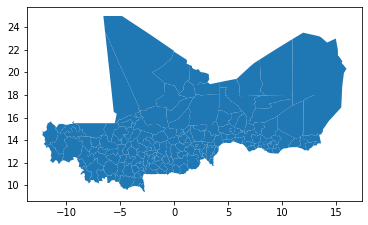

In [18]:
# READ SHAPEFILES - Downloaded from FEWS_IPC website
bf = gpd.read_file('Data/Shape/Burkina_Faso/BF_Admin2_2020.shp')
ml = gpd.read_file('Data/Shape/Mali/ML_Admin2_2001.shp')
ne = gpd.read_file('Data/Shape/Niger/NE_Admin2_2018.shp')

# Check crs projection
# bf.crs
# ml.crs
# ne.crs

# Create GeoDataFrame
shape = gpd.GeoDataFrame( pd.concat( [bf,ml,ne], ignore_index=True) )
shape = shape.drop(['FNID', 'EFF_YEAR', 'ADMIN1', 'ADMIN2FR', 'ADMIN1FR', 'ALIASES', 'ADMIN1PT', 'ADMIN2SP', 'ADMIN2PT',
                    'ADMIN1SP'], axis=1)
shape.rename(columns = {'ADMIN2':'admin_name'}, inplace = True)
shape['admin_name'] = shape['admin_name'].astype(str)
# Check number of admin codes in shapefile
# shape['ADMIN0'].value_counts()
# shape.plot()


## 2. Clean datasets

* Remove predictor variables and irrelevant covariates
* Restrict dataset to be between years 20010-2019
* Extend NAs were applicable to respect time series
* Check admin names for both shape gdf and food crises df (admin names need to be the same in order to merge correctly)
* Merge datasets

In [19]:
# Remove all predictors except fews_ipc
FS = FS.drop(['fews_ha', 'fews_proj_near', 'fews_proj_near_ha', 'fews_proj_med', 'fews_proj_med_ha'], axis=1)
# Remove anom variables to optimize independence
FS = FS.drop(['ndvi_anom', 'rain_anom', 'et_anom'], axis=1)

# Remove unnecessary years
FS.drop(FS.index[FS['year'] == 2007], inplace=True)
FS.drop(FS.index[FS['year'] == 2008], inplace=True)
FS.drop(FS.index[FS['year'] == 2009], inplace=True)
FS.drop(FS.index[FS['year'] == 2020], inplace=True)

# Extend NA's where applicable
FS.isnull().sum()
FS['fews_ipc'] = FS['fews_ipc'].fillna(method='ffill')
FS['et_mean'] = FS['et_mean'].fillna(method='ffill')

In [20]:
# Check strings and fix differences
shape['admin_name'] = shape['admin_name'].str.replace('-',' ')
FS['admin_name'] = FS['admin_name'].str.replace('-',' ')
shape['admin_name'] = shape['admin_name'].str.replace('é','e')
FS['admin_name'] = FS['admin_name'].str.replace('é','e')
shape['admin_name'] = shape['admin_name'].str.replace(' el',' El')
FS['admin_name'] = FS['admin_name'].str.replace('ô','o')
FS['admin_name'] = FS['admin_name'].str.replace('Komonjdjari','Komandjari')

# l = set(FS['admin_name'].tolist())
# x = set(shape['admin_name'].tolist())
# print('Names in FS df but not in shape gdf', set(list(l - x))) #FS data set
# print('Names in shape gdf but not in FS df', set(list(x - l))) #shape dataset

**Merge data int single dataframe**

In [22]:
# Merge data on admin_name
df = pd.merge(shape, FS, on='admin_name')
# Reorder columns
df = df.drop(['COUNTRY', 'ADMIN0'], axis=1)
df = df[['country', 'admin_code', 'admin_name', 'centx', 'centy', 'year_month', 'year', 'month', 'fews_ipc', 'ndvi_mean', 'rain_mean', 'et_mean', 'acled_count', 'acled_fatalities', 'p_staple_food', 'area', 'cropland_pct', 'pop', 'ruggedness_mean', 'pasture_pct', 'geometry']]
df = df.sort_values(by=['country', 'admin_name'])

**Data manipulations for STDA**
* Transpose predictor variable (FEWs IPC classification) into matrix to make data manipulation easier

In [23]:
#### ** Data manipulations ** ####
y = df.groupby(['country', 'admin_name', 'year'])['fews_ipc'].mean().reset_index()
m = df.groupby(['country', 'admin_name', 'month'])['fews_ipc'].mean().reset_index()
ym = df.groupby(['country', 'admin_name', 'year_month'])['fews_ipc'].mean().reset_index()
# transpose matrix & row means
year_m = y.pivot(index='admin_name', columns='year', values='fews_ipc')
month_m = m.pivot(index='admin_name', columns='month', values='fews_ipc')
yearmonth_m = ym.pivot(index='admin_name', columns='year_month', values='fews_ipc')